In [1]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import importlib
import os
from sklearn.metrics import confusion_matrix
import config
importlib.reload(config)
from config import BIN_SIZE, STRATIFY_BY, ANALYSIS_MODE
import joblib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import get_stable_pipeline, preprocess_data

In [2]:
# Configuration
MODEL_PATH = 'final_lasso_model.joblib'
FEATURES_PATH = 'model_features.joblib'
HOLDOUT_MATRIX_PATH = "/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/dataframes_holdout/ratio_final_feature_matrix_gc_corrected_50000.tsv"
BIN_SIZE = 50000

print("--- Final Holdout Validation ---")

--- Final Holdout Validation ---


In [ ]:
model = joblib.load(MODEL_PATH)

model_step = model.named_steps['stable_model']
c_wert = model_step.C
print(f"Der verwendete C-Wert ist: {c_wert}")


Der verwendete C-Wert ist: 3.5564803062231287


In [ ]:
print("Modell Struktur:")
print(model)

model_step = model.named_steps['stable_model']

print("\n--- Modell Parameter ---")
print(f"Gewählter C-Wert (c_1se): {model_step.C}")
print(f"Penalty (Lasso/Ridge):   {model_step.penalty}")
print(f"Solver:                  {model_step.solver}")

n_features = np.sum(model_step.coef_ != 0)
model_features = joblib.load('model_features.joblib')
print(f"Anzahl relevanter Bins:  {n_features} von {len(model_features)}")

needed_metrics = list(set([f.split('_chr')[0] for f in model_features]))
print(f"Metrics required by model: {needed_metrics}")

Modell Struktur:
Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=0.0, keep_empty_features=True,
                               strategy='constant')),
                ('scaler', StandardScaler()),
                ('stable_model',
                 LogisticRegression(C=3.5564803062231287, max_iter=10000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

--- Modell Parameter ---
Gewählter C-Wert (c_1se): 3.5564803062231287
Penalty (Lasso/Ridge):   l1
Solver:                  liblinear
Anzahl relevanter Bins:  142 von 8520
Metrics required by model: ['stdev', 'median']


In [5]:
# 3. Load Holdout Data
print("Loading holdout matrix...")
if not os.path.exists(HOLDOUT_MATRIX_PATH):
    print(f"ERROR: Holdout matrix not found at {HOLDOUT_MATRIX_PATH}")
    exit(1)

df_holdout = pd.read_csv(HOLDOUT_MATRIX_PATH, sep="\t")
df_holdout = df_holdout[~df_holdout["group"].isin(["duodenal", "esophageal"])]


Loading holdout matrix...


In [ ]:
# 4. Prepare Holdout Features (Pivoting)
print("Formatting holdout features to match model structure...")
df_holdout["bin_id"] = df_holdout["chrom"] + "_" + df_holdout["start"].astype(str)
X_holdout_raw = df_holdout.pivot(index="sample", columns="bin_id", values=needed_metrics)
X_holdout_raw.columns = [f"{m}_{bid}" for m, bid in X_holdout_raw.columns]
X_holdout = X_holdout_raw.reindex(columns=model_features, fill_value=0)
print(f"Feature alignment complete. Shape: {X_holdout.shape}")

Formatting holdout features to match model structure...
Feature alignment complete. Shape: (27, 8520)


In [7]:
missing = set(model_features) - set(X_holdout.columns)
print(len(missing))


0


In [8]:
import numpy as np
import pandas as pd

scaler = model.named_steps["scaler"]

# Z-Scores des Holdouts relativ zur Trainingsverteilung
Z = (X_holdout.values - scaler.mean_) / scaler.scale_

# 1) Wie extrem ist Holdout insgesamt?
absZ = np.abs(Z)
print("max |z|:", np.nanmax(absZ))
print("percentiles |z|:", np.nanpercentile(absZ, [50, 90, 95, 99, 99.9]))

# 2) Welche Features sind am stärksten "off"?
max_absZ_per_feature = np.nanmax(absZ, axis=0)
top_idx = np.argsort(max_absZ_per_feature)[::-1][:20]

top_shift = pd.Series(max_absZ_per_feature[top_idx], index=X_holdout.columns[top_idx])
display(top_shift)

# 3) Wie viele Werte sind extrem außerhalb?
print("fraction |z|>5:", np.nanmean(absZ > 5))
print("fraction |z|>10:", np.nanmean(absZ > 10))


max |z|: 1422.8841061950448
percentiles |z|: [ 0.65291445  2.27481252  3.95756698 11.62390336 33.34189168]


/tmp/ipykernel_1673593/103121805.py:15: RuntimeWarning: All-NaN slice encountered
  max_absZ_per_feature = np.nanmax(absZ, axis=0)


stdev_chr1_144700000             NaN
stdev_chr7_63350000              NaN
median_chr7_63350000             NaN
stdev_chr1_144150000             NaN
stdev_chr7_75300000              NaN
median_chr21_34450000            NaN
stdev_chr17_38000000             NaN
stdev_chr21_34450000             NaN
stdev_chr21_34400000             NaN
stdev_chr16_22500000             NaN
median_chr1_144150000    1422.884106
median_chr7_75300000      549.037340
median_chr2_20650000      203.028860
median_chr9_96900000      199.076789
median_chr4_3200000       184.017621
median_chr14_73500000     178.145271
median_chr16_49850000     155.287344
median_chr7_101350000     154.710155
median_chr9_137450000     154.330355
median_chr5_1150000       151.524025
dtype: float64

fraction |z|>5: 0.03714136671883151
fraction |z|>10: 0.013110763345505129


In [22]:
feat = "median_chr1_144150000"

print("Train mean:", scaler.mean_[X_holdout.columns.get_loc(feat)])
print("Train std:", scaler.scale_[X_holdout.columns.get_loc(feat)])

print("Holdout mean:", X_holdout[feat].mean())
print("Holdout min/max:", X_holdout[feat].min(), X_holdout[feat].max())


Train mean: -0.000343433236390362
Train std: 0.004303206117958624
Holdout mean: -4.682392274600398
Holdout min/max: -6.123307024160996 -3.915751901179188


In [10]:
# 5. Extract Ground Truth (y_holdout)
# We use the 'group' column which contains the folder names (healthy, pancreatic, etc.)
group_info = df_holdout[['sample', 'group']].drop_duplicates().set_index('sample')
# 1 if cancer, 0 if healthy
y_holdout = (group_info.loc[X_holdout.index, "group"].str.lower() != "healthy").astype(int).values


In [11]:
# 6. Prediction
print(f"Running prediction on {len(X_holdout)} samples...")
probs = model.predict_proba(X_holdout)[:, 1]

Running prediction on 27 samples...


In [12]:
# 7. Evaluation (AUC Score)
auc_score = roc_auc_score(y_holdout, probs)
print(f"\n" + "="*40)
print(f"FINAL HOLDOUT AUC: {auc_score:.4f}")
print("="*40 + "\n")


FINAL HOLDOUT AUC: 0.4500



In [13]:
# 8. Save Results
output_dir = "holdout_preprocessing/results"
os.makedirs(output_dir, exist_ok=True)
results_df = pd.DataFrame({
    'sample': X_holdout.index,
    'prediction_score': probs,
    'true_label': y_holdout
})
results_df.to_csv(f"{output_dir}/holdout_validation_results.csv", index=False)


Detailed results and plots saved in 'holdout_preprocessing/'.


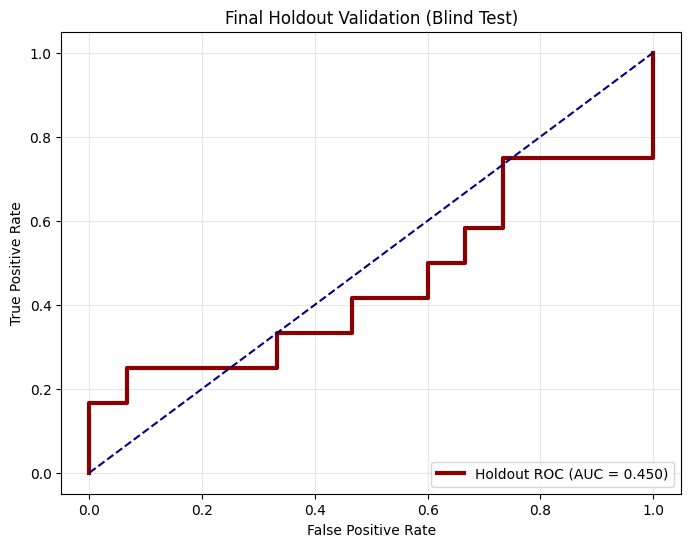

In [14]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_holdout, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', lw=3, label=f'Holdout ROC (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Holdout Validation (Blind Test)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig("holdout_preprocessing/plots/holdout_final_roc_joblib.png")
print("Detailed results and plots saved in 'holdout_preprocessing/'.")

In [15]:
# 5.5 DIAGNOSTIC: Check what's happening
print("="*80)
print("DIAGNOSTIC: Label & Prediction Analysis")
print("="*80)

preds = (probs > 0.5).astype(int)

print(f"\n1. Label Distribution:")
print(f"   0 (Healthy): {np.sum(y_holdout == 0)} samples")
print(f"   1 (Cancer):  {np.sum(y_holdout == 1)} samples")

print(f"\n2. Prediction Distribution:")
print(f"   0 (Predicted Healthy): {np.sum(preds == 0)} samples")
print(f"   1 (Predicted Cancer):  {np.sum(preds == 1)} samples")

print(f"\n3. Probability Statistics:")
print(f"   Min:    {probs.min():.4f}")
print(f"   Max:    {probs.max():.4f}")
print(f"   Mean:   {probs.mean():.4f}")
print(f"   Median: {np.median(probs):.4f}")

tn, fp, fn, tp = confusion_matrix(y_holdout, preds).ravel()
print(f"\n4. Confusion Matrix:")
print(f"   TP: {tp:2d}  FP: {fp:2d}")
print(f"   FN: {fn:2d}  TN: {tn:2d}")

print(f"\n5. Sample-by-Sample Breakdown:")
results_diag = pd.DataFrame({
    'sample': X_holdout.index,
    'group': group_info.loc[X_holdout.index, 'group'].values,
    'true_label': y_holdout,
    'prob_cancer': probs,
    'pred_label': preds
})
print(results_diag.sort_values('prob_cancer', ascending=False).to_string())

print(f"\n6. AUC Test - Check if labels are inverted:")
y_flipped = 1 - y_holdout
from sklearn.metrics import roc_auc_score
auc_flipped = roc_auc_score(y_flipped, probs)
print(f"   Current AUC:       {roc_auc_score(y_holdout, probs):.4f}")
print(f"   AUC with flipped labels: {auc_flipped:.4f}")
if auc_flipped > 0.8:
    print(f"   ⚠️  ALERT: Labels might be INVERTED! AUC improves to {auc_flipped:.4f}")

print("="*80)

DIAGNOSTIC: Label & Prediction Analysis

1. Label Distribution:
   0 (Healthy): 15 samples
   1 (Cancer):  12 samples

2. Prediction Distribution:
   0 (Predicted Healthy): 13 samples
   1 (Predicted Cancer):  14 samples

3. Probability Statistics:
   Min:    0.0001
   Max:    1.0000
   Mean:   0.5362
   Median: 0.5026

4. Confusion Matrix:
   TP:  5  FP:  9
   FN:  7  TN:  6

5. Sample-by-Sample Breakdown:
     sample       group  true_label  prob_cancer  pred_label
0   EE85723  colorectal           1     1.000000           1
1   EE85724  colorectal           1     0.996620           1
4   EE85757     healthy           0     0.976012           1
21  EE87786    bileduct           1     0.974790           1
13  EE85842     healthy           0     0.973671           1
17  EE85878     healthy           0     0.914871           1
8   EE85787     healthy           0     0.863367           1
16  EE85861     healthy           0     0.857462           1
25  EE87894     gastric           1     

In [16]:
df_holdout[df_holdout["group"] =="pancreatic"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
76680,EE86244,pancreatic,chr1,18,0.021395,-0.079211,-0.088846,0.040469,-0.272749,-0.177361,900000,950000,0.63236,chr1_900000
76681,EE86244,pancreatic,chr1,21,0.028760,-0.068660,0.240717,-0.059853,0.249760,0.132722,1050000,1100000,0.62400,chr1_1050000
76682,EE86244,pancreatic,chr1,23,0.025538,0.026998,0.056385,0.099594,0.065222,-0.014300,1150000,1200000,0.59202,chr1_1150000
76683,EE86244,pancreatic,chr1,25,0.110401,0.288653,-0.017412,-0.233043,0.013496,-0.137768,1250000,1300000,0.60030,chr1_1250000
76684,EE86244,pancreatic,chr1,26,-0.003377,0.040563,0.004876,-0.049714,0.081162,-0.027780,1300000,1350000,0.64590,chr1_1300000
76685,EE86244,pancreatic,chr1,27,-0.141754,-0.152257,-0.161961,-0.037430,-0.143259,0.076899,1350000,1400000,0.56750,chr1_1350000
76686,EE86244,pancreatic,chr1,28,-0.035951,-0.120083,0.012689,-0.011853,-0.069659,0.025327,1400000,1450000,0.57180,chr1_1400000
76687,EE86244,pancreatic,chr1,30,-0.022464,-0.065711,0.090511,-0.173116,0.059885,0.143180,1500000,1550000,0.59168,chr1_1500000
76688,EE86244,pancreatic,chr1,32,0.160834,0.314007,0.067898,-0.143149,0.229801,-0.205870,1600000,1650000,0.60602,chr1_1600000
76689,EE86244,pancreatic,chr1,33,0.225061,0.403443,-0.145756,0.125729,-0.170754,-0.046786,1650000,1700000,0.52990,chr1_1650000


In [17]:
df_holdout[df_holdout["group"] =="gastric"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
115020,EE87893,gastric,chr1,18,-0.015102,0.009789,0.198247,-0.040322,0.083241,0.203620,900000,950000,0.63236,chr1_900000
115021,EE87893,gastric,chr1,21,0.068868,0.053632,-0.269456,0.240557,0.081787,0.360892,1050000,1100000,0.62400,chr1_1050000
115022,EE87893,gastric,chr1,23,0.017708,0.021201,-0.167483,0.108311,-0.028280,-0.001302,1150000,1200000,0.59202,chr1_1150000
115023,EE87893,gastric,chr1,25,0.039910,0.021246,0.016687,0.051749,0.066590,-0.235719,1250000,1300000,0.60030,chr1_1250000
115024,EE87893,gastric,chr1,26,0.022235,0.007625,-0.125825,0.046892,-0.003454,0.326806,1300000,1350000,0.64590,chr1_1300000
115025,EE87893,gastric,chr1,27,0.019266,0.026549,0.166007,-0.093172,0.139474,0.046283,1350000,1400000,0.56750,chr1_1350000
115026,EE87893,gastric,chr1,28,0.014165,-0.000288,0.181557,-0.080121,0.018281,0.250188,1400000,1450000,0.57180,chr1_1400000
115027,EE87893,gastric,chr1,30,0.002733,-0.039412,0.060451,0.072607,-0.025119,-0.047474,1500000,1550000,0.59168,chr1_1500000
115028,EE87893,gastric,chr1,32,-0.012971,-0.019557,-0.126988,0.014452,-0.046655,0.049967,1600000,1650000,0.60602,chr1_1600000
115029,EE87893,gastric,chr1,33,-0.081675,-0.076097,0.105411,-0.153610,-0.103619,-0.470368,1650000,1700000,0.52990,chr1_1650000


In [18]:
df_holdout[df_holdout["group"] =="colorectal"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id
0,EE85723,colorectal,chr1,18,-0.037653,-0.414185,0.183767,-0.460968,-0.079936,-0.046841,900000,950000,0.63236,chr1_900000
1,EE85723,colorectal,chr1,21,-0.027837,0.020936,-1.327991,0.566412,-0.280904,0.061068,1050000,1100000,0.62400,chr1_1050000
2,EE85723,colorectal,chr1,23,-0.172206,-0.091648,-0.245088,-0.421273,-0.242365,-0.002581,1150000,1200000,0.59202,chr1_1150000
3,EE85723,colorectal,chr1,25,0.038371,0.075498,-0.948862,0.667597,-0.201435,0.062528,1250000,1300000,0.60030,chr1_1250000
4,EE85723,colorectal,chr1,26,-0.187051,-0.139926,-0.706720,0.063884,-0.311789,-0.054679,1300000,1350000,0.64590,chr1_1300000
5,EE85723,colorectal,chr1,27,-0.083949,-0.052648,0.720442,-1.084348,0.046464,0.140460,1350000,1400000,0.56750,chr1_1350000
6,EE85723,colorectal,chr1,28,-0.055716,-0.103770,0.200428,-0.705945,-0.045330,-0.058558,1400000,1450000,0.57180,chr1_1400000
7,EE85723,colorectal,chr1,30,0.069030,-0.004583,-0.685825,0.645244,-0.141606,0.035854,1500000,1550000,0.59168,chr1_1500000
8,EE85723,colorectal,chr1,32,0.183719,0.130657,-0.729934,0.805645,-0.067221,-0.033980,1600000,1650000,0.60602,chr1_1600000
9,EE85723,colorectal,chr1,33,-0.229078,-0.408682,0.227718,-2.450050,-0.217977,0.166757,1650000,1700000,0.52990,chr1_1650000


In [23]:
print(df_holdout[["mean", "median"]].mean())


mean     -0.000090
median   -0.000798
dtype: float64


In [20]:
df_holdout[df_holdout["group"] =="esophageal"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,bin_id


In [21]:
# --- FEATURE TREND ANALYSIS (In dein Validierungs-Skript einfügen) ---
print("\n" + "="*60)
print("FEATURE TREND ANALYSIS: Training (from Scaler) vs. Holdout")
print("="*60)

# 1. Hol dir die Koeffizienten und den Scaler aus der geladenen Pipeline
scaler = model.named_steps['scaler']
stable_model = model.named_steps['stable_model']
coeffs = stable_model.coef_[0]

# 2. Finde die Top 5 Features (stärkste Auswirkung auf die Entscheidung)
top_indices = np.argsort(np.abs(coeffs))[::-1][:5]
top_features = [model_features[i] for i in top_indices]

comparison_results = []

for idx in top_indices:
    feat_name = model_features[idx]
    
    # Trainings-Info: Der Scaler "weiß" noch den Mittelwert aus dem Training
    train_mean = scaler.mean_[idx]
    train_coeff = coeffs[idx]
    
    # Holdout-Info: Tatsächliche Werte in deinem aktuellen Datensatz
    h_healthy = X_holdout.loc[y_holdout == 0, feat_name].mean()
    h_cancer = X_holdout.loc[y_holdout == 1, feat_name].mean()
    h_trend = h_cancer - h_healthy  # Positiv, wenn Cancer > Healthy
    
    comparison_results.append({
        'Feature': feat_name,
        'Coeff (Train)': train_coeff,
        'Train_Mean_Total': train_mean,
        'Holdout_Healthy': h_healthy,
        'Holdout_Cancer': h_cancer,
        'Holdout_Trend': h_trend
    })

df_trends = pd.DataFrame(comparison_results)
print(df_trends.to_string(index=False))

# 3. Logik-Check für die Inversion
print("\n--- INVERSION CHECK ---")
for _, row in df_trends.iterrows():
    # Wenn Coeff > 0, erwartet das Modell: Cancer > Healthy
    # Wenn Coeff < 0, erwartet das Modell: Cancer < Healthy
    expected_positive_trend = row['Coeff (Train)'] > 0
    actual_positive_trend = row['Holdout_Trend'] > 0
    
    if expected_positive_trend != actual_positive_trend:
        print(f"⚠️  INVERSION in {row['Feature']}:")
        print(f"   Model expects {'INCREASE' if expected_positive_trend else 'DECREASE'} for Cancer.")
        print(f"   Data shows {'INCREASE' if actual_positive_trend else 'DECREASE'} in Holdout.")
    else:
        print(f"✅ Trend for {row['Feature']} is consistent with training logic.")
        


FEATURE TREND ANALYSIS: Training (from Scaler) vs. Holdout
              Feature  Coeff (Train)  Train_Mean_Total  Holdout_Healthy  Holdout_Cancer  Holdout_Trend
  stdev_chr4_42150000      -0.743884          0.010297         0.059719       -0.077632      -0.137350
 stdev_chr5_171350000      -0.715640          0.027516         0.020496        0.136015       0.115519
median_chr11_60850000       0.680557          0.011629         0.013898       -0.005919      -0.019817
median_chr17_29900000       0.574162         -0.000071         0.006441        0.052717       0.046276
 median_chr11_1950000       0.528406         -3.688006       -10.578932       -3.402668       7.176265

--- INVERSION CHECK ---
✅ Trend for stdev_chr4_42150000 is consistent with training logic.
⚠️  INVERSION in stdev_chr5_171350000:
   Model expects DECREASE for Cancer.
   Data shows INCREASE in Holdout.
⚠️  INVERSION in median_chr11_60850000:
   Model expects INCREASE for Cancer.
   Data shows DECREASE in Holdout.
✅ Tre